In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
device = torch.device('cuda') if (torch.cuda.is_available()) else torch.device('cpu')
device

device(type='cuda')

In [4]:
# complete = pd.read_csv('EOF_Bath_SPacific.csv')
complete = pd.read_csv('/kaggle/input/argo-data/FullSPacific.csv')
complete

,Unnamed: 0,folderidx,float,profileidx,year,month,day,lat,lon,nlat,...,prev_ts5,prev_ts6,prev_ts7,prev_ts8,prev_dy,prev_dx,ssh1,ssh2,bath1,bath2
0,122,2.0,2902573.0,125.0,2017.0,3.0,3.0,-27.995,-120.065,-28.145,...,0.342933,0.443193,-0.442858,0.514106,-0.128,-0.221,1.000000,-1.587225,1.000000,0.031732
1,123,2.0,2902573.0,126.0,2017.0,3.0,13.0,-28.145,-120.164,-28.267,...,0.259838,0.461459,-0.452919,0.496550,-0.150,-0.099,1.000000,-0.779453,1.000000,0.200338
2,125,2.0,2902573.0,128.0,2017.0,4.0,3.0,-28.250,-120.344,-28.163,...,0.534783,0.603244,-0.601384,0.508919,0.017,-0.128,1.000000,0.031837,1.000000,0.073253
3,126,2.0,2902573.0,129.0,2017.0,4.0,13.0,-28.163,-120.430,-27.990,...,0.640600,1.051018,-0.737335,0.710894,0.087,-0.086,1.000000,5.277296,1.000000,0.232778
4,127,2.0,2902573.0,130.0,2017.0,4.0,22.0,-27.990,-120.652,-27.808,...,0.540655,0.741024,-0.644372,0.550055,0.173,-0.222,1.000000,18.858501,-0.068842,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29986,59038,10.0,3902389.0,134.0,2022.0,8.0,30.0,-20.123,-109.789,-20.091,...,1.127813,0.338755,-0.503737,-0.133409,-0.007,0.128,-0.551358,1.000000,-7.737074,1.000000
29987,59039,10.0,3902389.0,135.0,2022.0,9.0,9.0,-20.091,-109.661,-20.018,...,1.231033,0.700594,-0.679503,-0.065859,0.032,0.128,-0.028281,1.000000,-4.334649,1.000000
29988,59040,10.0,3902389.0,136.0,2022.0,9.0,19.0,-20.018,-109.584,-19.891,...,1.312617,0.767989,-0.819506,0.113578,0.073,0.077,-0.086688,1.000000,-3.750459,1.000000
29989,59041,10.0,3902389.0,154.0,2023.0,3.0,17.0,-20.220,-108.673,-20.056,...,1.092594,-0.028627,-0.405811,-0.383263,-0.252,0.315,1.000000,-0.146425,-7.538328,1.000000


In [5]:
scales = [max(i) for i in np.abs(complete[['bath1', 'bath2']].to_numpy())]
complete = complete.assign(bath1 = complete.get('bath1') / scales).assign(bath2 = complete.get('bath2') / scales)
scales = [max(i) for i in np.abs(complete[['ssh1', 'ssh2']].to_numpy())]
complete = complete.assign(ssh1 = complete.get('ssh1') / scales).assign(ssh2 = complete.get('ssh2') / scales)
complete.head(50)

,Unnamed: 0,folderidx,float,profileidx,year,month,day,lat,lon,nlat,...,prev_ts5,prev_ts6,prev_ts7,prev_ts8,prev_dy,prev_dx,ssh1,ssh2,bath1,bath2
0,122,2.0,2902573.0,125.0,2017.0,3.0,3.0,-27.995,-120.065,-28.145,...,0.342933,0.443193,-0.442858,0.514106,-0.128,-0.221,0.630030,-1.000000,1.000000,0.031732
1,123,2.0,2902573.0,126.0,2017.0,3.0,13.0,-28.145,-120.164,-28.267,...,0.259838,0.461459,-0.452919,0.496550,-0.150,-0.099,1.000000,-0.779453,1.000000,0.200338
2,125,2.0,2902573.0,128.0,2017.0,4.0,3.0,-28.250,-120.344,-28.163,...,0.534783,0.603244,-0.601384,0.508919,0.017,-0.128,1.000000,0.031837,1.000000,0.073253
3,126,2.0,2902573.0,129.0,2017.0,4.0,13.0,-28.163,-120.430,-27.990,...,0.640600,1.051018,-0.737335,0.710894,0.087,-0.086,0.189491,1.000000,1.000000,0.232778
4,127,2.0,2902573.0,130.0,2017.0,4.0,22.0,-27.990,-120.652,-27.808,...,0.540655,0.741024,-0.644372,0.550055,0.173,-0.222,0.053026,1.000000,-0.068842,1.000000
5,128,2.0,2902573.0,131.0,2017.0,5.0,2.0,-27.808,-120.970,-27.651,...,0.564260,0.800196,-0.607703,0.579257,0.182,-0.318,0.471371,1.000000,0.450265,1.000000
6,129,2.0,2902573.0,132.0,2017.0,5.0,12.0,-27.651,-121.421,-27.609,...,0.495979,0.972258,-0.630542,0.705496,0.157,-0.451,0.104666,1.000000,-0.340642,1.000000
7,130,2.0,2902573.0,133.0,2017.0,5.0,22.0,-27.609,-121.743,-27.623,...,0.479878,0.958020,-0.599921,0.718801,0.042,-0.322,0.082962,1.000000,1.000000,0.299927
8,131,2.0,2902573.0,134.0,2017.0,6.0,2.0,-27.623,-122.033,-27.590,...,0.496789,0.638251,-0.491562,0.595884,-0.014,-0.290,0.088565,-1.000000,0.717516,1.000000
9,132,2.0,2902573.0,135.0,2017.0,6.0,12.0,-27.590,-122.403,-27.542,...,0.628706,0.673461,-0.626352,0.626316,0.033,-0.370,0.304397,1.000000,1.000000,0.729499


In [7]:
data = complete
# find correlation between prev_dx and dx
prev_dx = data.get('prev_dx')
dx = data.get('dx')
prev_dy = data.get('prev_dy')
dy = data.get('dy')
dx.corr(prev_dx), dy.corr(prev_dy)

(0.7267506485337688, 0.6799595535165472)

In [8]:
# chosen_params = ['bath1', 'bath2', 'prev_dy', 'prev_dx', 'dy', 'dx']
chosen_params = ['ts1', 'ts2', 'ts3', 'ts4', 'ts5', 'ts6', 'ts7', 'ts8',
  'prev_ts1', 'prev_ts2', 'prev_ts3', 'prev_ts4', 'prev_ts5', 'prev_ts6',
  'prev_ts7', 'prev_ts8', 'bath1', 'bath2', 'ssh1', 'ssh2', 'prev_dy', 'prev_dx', 'dy', 'dx']
# chosen_params = ['ts1', 'ts2', 'ts3', 'ts4', 'ts5', 'ts6', 'ts7', 'ts8', 'prev_dy', 'prev_dx', 'dy', 'dx']
# chosen_params = ['prev_dy', 'prev_dx', 'dy', 'dx']
# chosen_params = ['ts1', 'ts2', 'ts3', 'ts4', 'ts5', 'ts6', 'ts7', 'ts8', 'bath1', 'bath2', 'prev_dy', 'prev_dx', 'dy', 'dx']

final = data[chosen_params].dropna()
final

,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,prev_ts1,prev_ts2,...,prev_ts7,prev_ts8,bath1,bath2,ssh1,ssh2,prev_dy,prev_dx,dy,dx
0,1.192006,-5.597361,-0.062255,0.513387,0.259838,0.461459,-0.452919,0.496550,0.988142,-5.643554,...,-0.442858,0.514106,1.000000,0.031732,0.630030,-1.000000,-0.128,-0.221,-0.150,-0.099
1,0.486643,-5.805338,-0.495626,1.023332,0.482292,0.711307,-0.636107,0.681706,1.192006,-5.597361,...,-0.452919,0.496550,1.000000,0.200338,1.000000,-0.779453,-0.150,-0.099,-0.122,-0.052
2,-1.246517,-6.414328,-1.303555,1.538312,0.640600,1.051018,-0.737335,0.710894,-0.166054,-6.147102,...,-0.601384,0.508919,1.000000,0.073253,1.000000,0.031837,0.017,-0.128,0.087,-0.086
3,-0.670537,-6.280565,-0.912565,1.185883,0.540655,0.741024,-0.644372,0.550055,-1.246517,-6.414328,...,-0.737335,0.710894,1.000000,0.232778,0.189491,1.000000,0.087,-0.086,0.173,-0.222
4,-0.834957,-6.249685,-0.981255,1.231438,0.564260,0.800196,-0.607703,0.579257,-0.670537,-6.280565,...,-0.644372,0.550055,-0.068842,1.000000,0.053026,1.000000,0.173,-0.222,0.182,-0.318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29986,-0.103917,-4.516683,0.146737,1.949804,1.231033,0.700594,-0.679503,-0.065859,0.116208,-4.428133,...,-0.503737,-0.133409,-1.000000,0.129248,-0.551358,1.000000,-0.007,0.128,0.032,0.128
29987,-0.704889,-4.651527,-0.076126,2.052576,1.312617,0.767989,-0.819506,0.113578,-0.103917,-4.516683,...,-0.679503,-0.065859,-1.000000,0.230699,-0.028281,1.000000,0.032,0.128,0.073,0.077
29988,-0.826809,-4.662544,-0.207767,2.174357,1.289403,0.986241,-0.897816,0.204583,-0.704889,-4.651527,...,-0.819506,0.113578,-1.000000,0.266634,-0.086688,1.000000,0.073,0.077,0.127,0.020
29989,-1.732734,-4.114318,-0.374978,1.175744,0.854125,-0.351473,0.190947,-0.836292,0.539132,-4.214100,...,-0.405811,-0.383263,-1.000000,0.132655,1.000000,-0.146425,-0.252,0.315,0.164,0.410


Coefficient of Multiple Correlation (R): 0.7132516433176687
mean square error: 0.016719697673312498


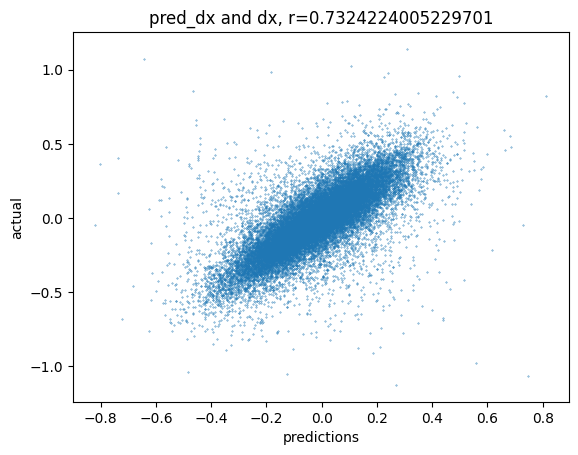

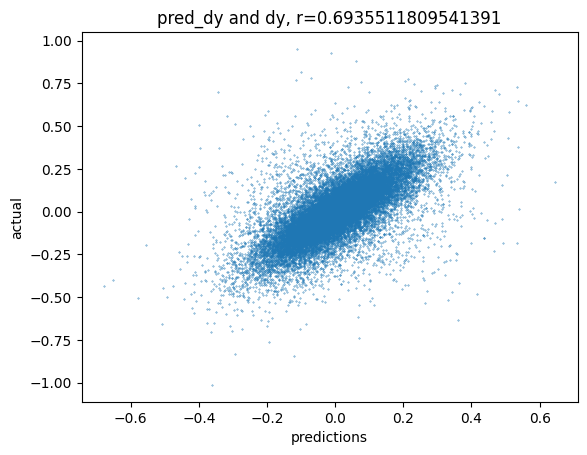

In [24]:
Y = final[['dy', 'dx']].to_numpy()
X = final.drop(columns=['dy', 'dx']).to_numpy()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression()
model.fit(X, Y)
Y_pred = model.predict(X)
r_squared = r2_score(Y, Y_pred)
R = np.sqrt(r_squared)

def corr_coef(x, y):
    num = np.mean(x * y) - np.mean(x)*np.mean(y)
    denom = np.std(x) * np.std(y)
    return num / denom

print("Coefficient of Multiple Correlation (R):", R)
# its 0.13 when not including prev profile
print('mean square error:', np.mean((Y_pred - final[['dy', 'dx']].to_numpy())**2))

plt.scatter(Y_pred[:, 1], Y[:, 1], s=.1)
plt.title(f'pred_dx and dx, r={corr_coef(Y[:, 1], Y_pred[:, 1])}')
plt.xlabel('predictions')
plt.ylabel('actual')
plt.show()

plt.scatter(Y_pred[:, 0], Y[:, 0], s=.1)
plt.title(f'pred_dy and dy, r={corr_coef(Y[:, 0], Y_pred[:, 0])}')
plt.xlabel('predictions')
plt.ylabel('actual')
plt.show()

X = torch.tensor(X).float()
Y = torch.tensor(Y).float()

In [7]:
model.coef_

array([[ 9.31836588e-03, -7.83776165e-02, -4.04219483e-02,
        -2.34154689e-02, -9.12554467e-02, -2.15277982e-02,
        -2.04139805e-02,  4.84472195e-03, -2.54539574e-02,
         6.79233519e-02,  7.39004469e-02,  5.26115826e-02,
         8.67585023e-03,  3.29335592e-02,  9.53442318e-04,
        -6.22428322e-02, -1.81031822e-04, -3.22689761e-03,
        -1.17735396e-02,  9.45330123e-03,  6.60218829e-01,
         2.76971674e-02],
       [ 9.62016006e-04, -3.42653591e-02, -6.71200260e-03,
        -1.34302762e-02, -2.52890682e-02, -1.21841665e-03,
         4.05185924e-03,  9.13322719e-03,  3.30965987e-03,
         3.77595254e-02,  7.57521329e-03,  8.57070324e-03,
         4.01609649e-02,  2.40873529e-02,  2.34919868e-03,
        -1.97566078e-02, -1.02235878e-03,  2.72161224e-03,
        -8.43790353e-03,  1.51252585e-02, -5.41585029e-02,
         6.96825015e-01]])

In [30]:
# TODO: instead of doing a naive shuffle, keep profiles specific to floats (or regions) grouped together
X, Y = shuffle(X, Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.11)

training loss: 0.013482388
training loss: 0.012380978
training loss: 0.011978889
training loss: 0.011526044
training loss: 0.011981387
training loss: 0.0119040115
training loss: 0.0117346505
training loss: 0.011879517
training loss: 0.011576187
training loss: 0.011029985
training loss: 0.010764717
training loss: 0.010769581
training loss: 0.0108313365
training loss: 0.010769705
training loss: 0.011006135
training loss: 0.01078868
training loss: 0.010678831
training loss: 0.010584901
training loss: 0.010408629
training loss: 0.010651692
training loss: 0.010772837
training loss: 0.0104984995
training loss: 0.010394589
training loss: 0.010278678
training loss: 0.009873282
test loss: 0.013785955


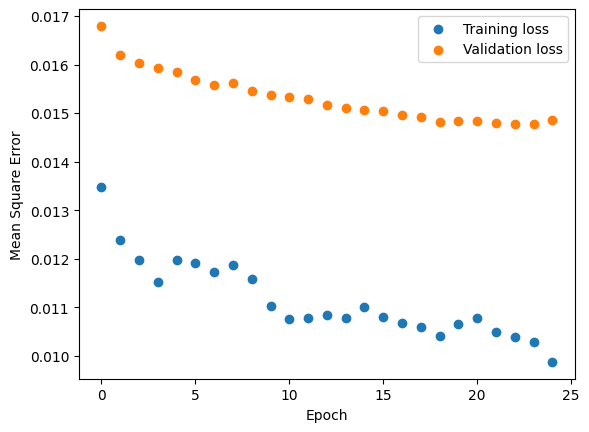

In [32]:
model = nn.Sequential(
    nn.Linear(X.size()[1], 32),
    nn.LeakyReLU(),
    nn.Linear(32, 16),
    nn.LeakyReLU(),
    nn.Linear(16, 2)
).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

# todo: try different batch sizes
batch_size = 32
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0

training_losses = []
val_losses = []
for epoch in range(25):
    for i in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        x_batch = X_train[i:i+batch_size].to(device)
        y_batch = Y_train[i:i+batch_size].to(device)
        guess = model(x_batch)
        loss = criterion(guess, y_batch)
        loss.backward()
        optimizer.step()
        
    training_losses.append(loss.cpu().detach().numpy())
    print("training loss:", training_losses[-1])
    
    with torch.no_grad():
        val_losses.append(criterion(model(X_val.to(device)), Y_val.to(device)).cpu().detach().numpy())
    
    # havent improved in the last 5, quit
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            break
            
with torch.no_grad():
    print("test loss:", criterion(model(X_test.to(device)), Y_test.to(device)).cpu().detach().numpy())
    
plt.scatter(np.arange(len(training_losses)), training_losses)
plt.scatter(np.arange(len(val_losses)), val_losses)
plt.xlabel('Epoch');
plt.ylabel('Mean Square Error')
plt.legend(['Training loss', 'Validation loss'])
plt.show()

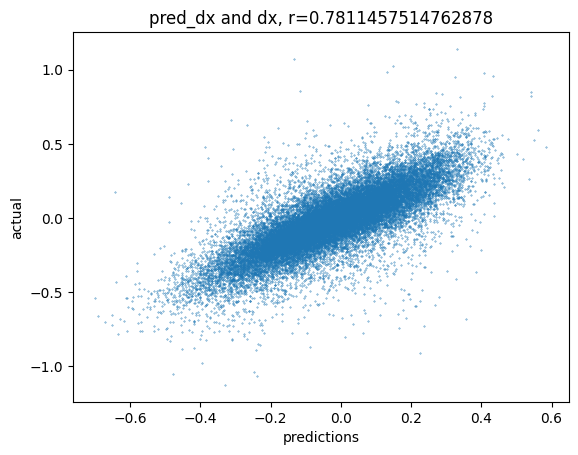

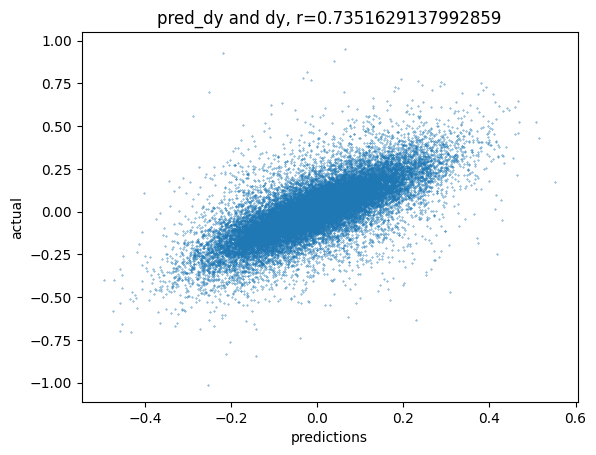

In [33]:
Y_pred = model(X.to(device)).cpu()

plt.scatter(Y_pred.detach().numpy()[:, 1], Y.detach().numpy()[:, 1], s=.1)
plt.title(f'pred_dx and dx, r={corr_coef(Y_pred.detach().numpy()[:, 1], Y.detach().numpy()[:, 1])}')
plt.xlabel('predictions')
plt.ylabel('actual')
plt.show()

plt.scatter(Y_pred.detach().numpy()[:, 0], Y.detach().numpy()[:, 0], s=0.1)
plt.title(f'pred_dy and dy, r={corr_coef(Y_pred.detach().numpy()[:, 0], Y.detach().numpy()[:, 0])}')
plt.xlabel('predictions')
plt.ylabel('actual')
plt.show()

In [34]:
# picking a contiguous sequence
just_one = data[data.get('float') == 2902573.0].head(13).tail(10)

small_test = torch.tensor(just_one[chosen_params[:-2]].to_numpy()).float().to(device)
pred = model(small_test).detach().cpu().numpy()
# pred = model.predict(small_test)
just_one = just_one.assign(pnlat = pred[:, 0] + just_one.get('lat'))
just_one = just_one.assign(pnlon = pred[:, 1] + just_one.get('lon')).reset_index()
just_one

,index,Unnamed: 0,folderidx,float,profileidx,year,month,day,lat,lon,...,prev_ts7,prev_ts8,prev_dy,prev_dx,ssh1,ssh2,bath1,bath2,pnlat,pnlon
0,3,126,2.0,2902573.0,129.0,2017.0,4.0,13.0,-28.163,-120.430,...,-0.737335,0.710894,0.087,-0.086,0.189491,1.0,1.000000,0.232778,-28.113701,-120.541894
1,4,127,2.0,2902573.0,130.0,2017.0,4.0,22.0,-27.990,-120.652,...,-0.644372,0.550055,0.173,-0.222,0.053026,1.0,-0.068842,1.000000,-27.853770,-120.865917
2,5,128,2.0,2902573.0,131.0,2017.0,5.0,2.0,-27.808,-120.970,...,-0.607703,0.579257,0.182,-0.318,0.471371,1.0,0.450265,1.000000,-27.660092,-121.256888
3,6,129,2.0,2902573.0,132.0,2017.0,5.0,12.0,-27.651,-121.421,...,-0.630542,0.705496,0.157,-0.451,0.104666,1.0,-0.340642,1.000000,-27.508181,-121.795558
4,7,130,2.0,2902573.0,133.0,2017.0,5.0,22.0,-27.609,-121.743,...,-0.599921,0.718801,0.042,-0.322,0.082962,1.0,1.000000,0.299927,-27.593283,-122.028695
5,8,131,2.0,2902573.0,134.0,2017.0,6.0,2.0,-27.623,-122.033,...,-0.491562,0.595884,-0.014,-0.290,0.088565,-1.0,0.717516,1.000000,-27.673623,-122.314957
6,9,132,2.0,2902573.0,135.0,2017.0,6.0,12.0,-27.590,-122.403,...,-0.626352,0.626316,0.033,-0.370,0.304397,1.0,1.000000,0.729499,-27.563165,-122.720440
7,10,133,2.0,2902573.0,136.0,2017.0,6.0,22.0,-27.542,-122.539,...,-0.642854,0.566728,0.048,-0.136,0.313711,1.0,1.000000,0.424542,-27.529990,-122.684815
8,11,134,2.0,2902573.0,137.0,2017.0,7.0,2.0,-27.525,-122.640,...,-0.613615,0.668475,0.017,-0.101,0.047053,1.0,1.000000,0.305194,-27.537830,-122.756033
9,12,135,2.0,2902573.0,138.0,2017.0,7.0,11.0,-27.458,-122.627,...,-0.574593,0.582251,0.067,0.013,0.362961,1.0,1.000000,0.399969,-27.444449,-122.635649


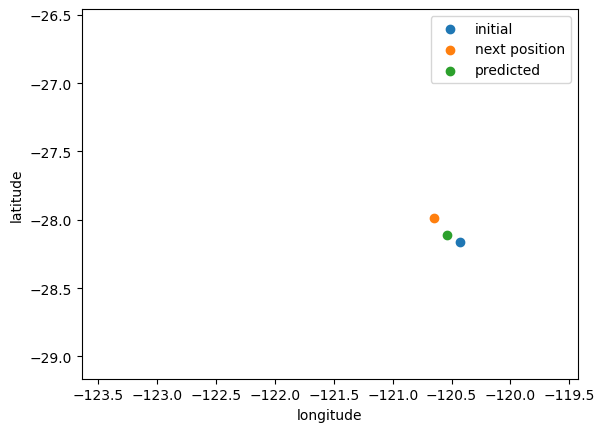

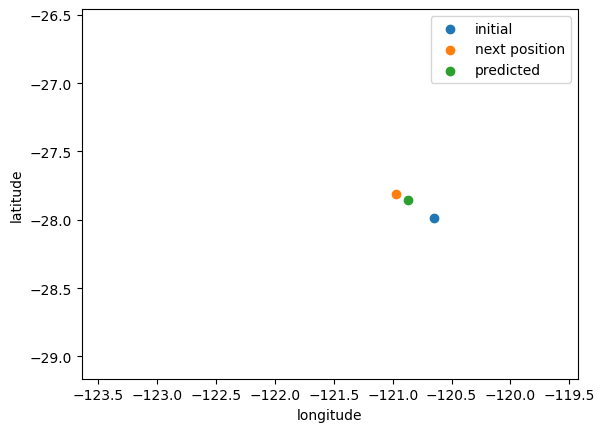

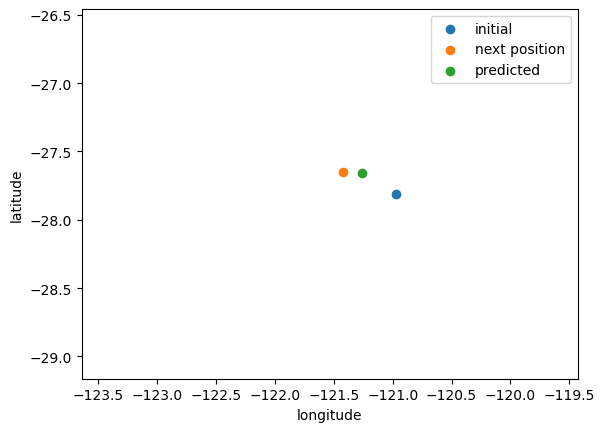

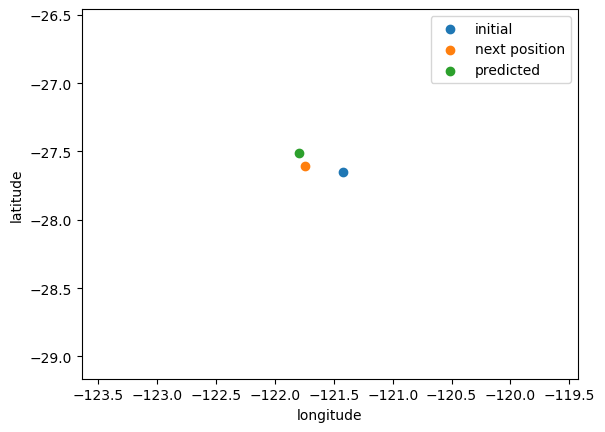

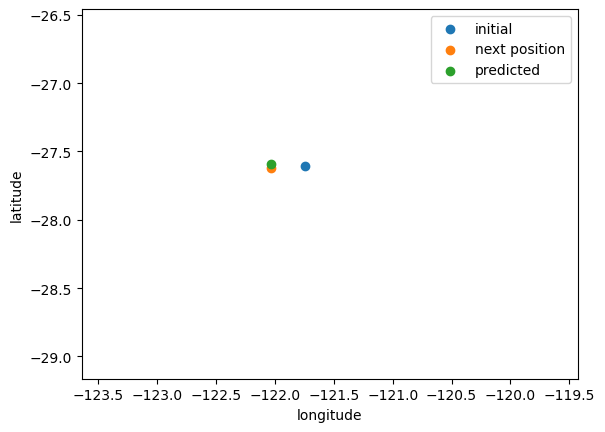

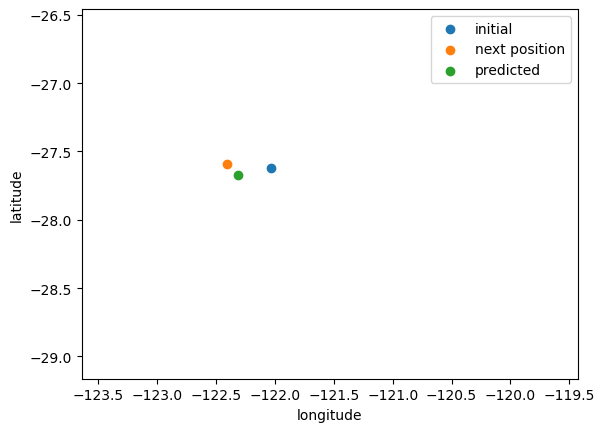

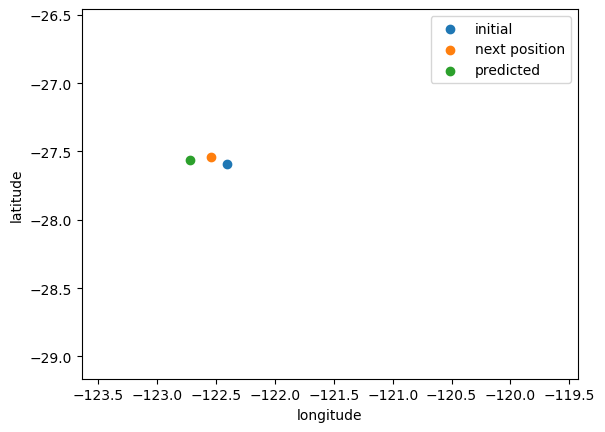

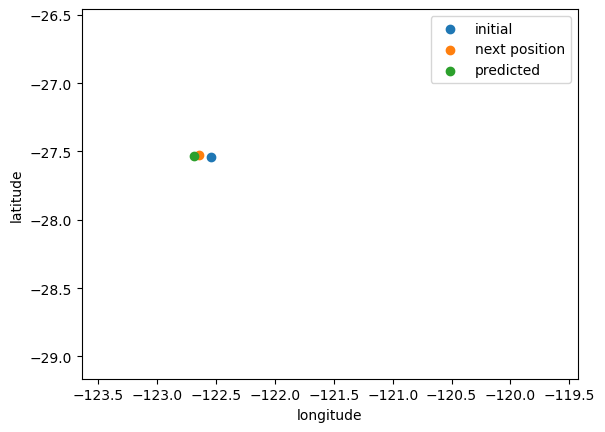

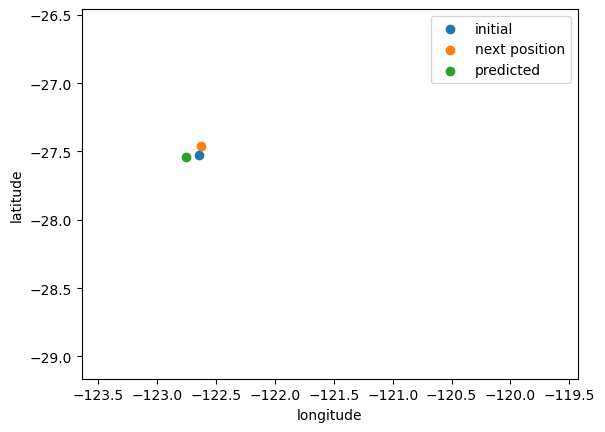

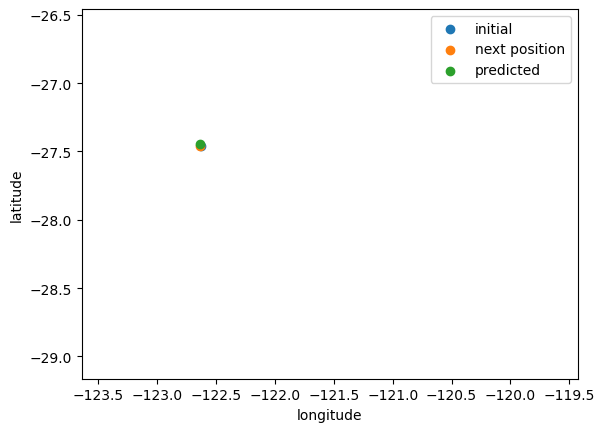

In [35]:
for i in range(just_one.shape[0]):
  y_plot = [just_one.get('lat')[i], just_one.get('nlat')[i], just_one.get('pnlat')[i]]
  x_plot = [just_one.get('lon')[i], just_one.get('nlon')[i], just_one.get('pnlon')[i]]
  for j in range(3):
    plt.scatter(x_plot[j], y_plot[j])
  plt.legend(['initial', 'next position', 'predicted'])
  plt.xlim((just_one.get('lon').min()-1, just_one.get('lon').max()+1))
  plt.ylim((just_one.get('lat').min()-1, just_one.get('lat').max()+1))
  plt.xlabel('longitude')
  plt.ylabel('latitude')
  plt.show()